<a href="https://colab.research.google.com/github/kys92/a.tcl-2021/blob/main/2021_tcl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##데이터셋 가져오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#!python --version
#import sklearn
#print(sklearn.__version__)

In [ ]:
# read dataset
dataset = pd.read_csv('./drive/My Drive/Colab Notebooks/skcc_data/tcl_data.csv')

## EDA 및 결측치 처리

In [ ]:
dataset.head()

,recontract_flag,target_value,end_detail,new_flag,maker,brand,price,start_date,end_date,promise_month,real_month,sec_condition,sec_rate,start_dist,end_dist,age,sex,credit_grade,accident,fine_light,fine_heavy,delay_count,delay_sum
0,신규,0,만기해지(인수),신차,현대자동차,아반떼,19130000,20170311,20210310,48,48,보증보험(증권),25,0.0,50000.0,60.0,남,NaN,5,9,10,1,4700
1,신규,0,만기해지(인수),신차,쌍용자동차,티볼리,25210000,20170326,20210325,48,48,선수금,30,0.0,50000.0,51.0,여,NaN,1,1,2,0,0
2,신규,1,중도반납,신차,현대자동차,싼타페,37600000,20170520,20210310,48,46,보증보험(증권),20,0.0,111290.0,51.0,남,NaN,1,1,6,16,273100
3,신규,0,만기해지(인수),신차,현대자동차,투싼,25280000,20170222,20210221,48,48,보증보험(증권),30,0.0,20000.0,NaN,NaN,NaN,0,1,25,0,0
4,신규,0,만기해지(인수),신차,BMW,5-SERIES,73400000,20170313,20210312,48,48,보증보험(증권),20,10000.0,50000.0,47.0,남,2.0,1,0,0,0,0


In [ ]:
dataset.shape

(2045, 23)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2045 entries, 0 to 2044
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recontract_flag  2045 non-null   object 
 1   target_value     2045 non-null   int64  
 2   end_detail       2045 non-null   object 
 3   new_flag         2045 non-null   object 
 4   maker            2045 non-null   object 
 5   brand            2045 non-null   object 
 6   price            2045 non-null   int64  
 7   start_date       2045 non-null   int64  
 8   end_date         2045 non-null   int64  
 9   promise_month    2045 non-null   int64  
 10  real_month       2045 non-null   int64  
 11  sec_condition    2045 non-null   object 
 12  sec_rate         2045 non-null   int64  
 13  start_dist       2016 non-null   float64
 14  end_dist         1880 non-null   float64
 15  age              2034 non-null   float64
 16  sex              2004 non-null   object 
 17  credit_grade  

In [ ]:
dataset.isnull().sum()

recontract_flag      0
target_value         0
end_detail           0
new_flag             0
maker                0
brand                0
price                0
start_date           0
end_date             0
promise_month        0
real_month           0
sec_condition        0
sec_rate             0
start_dist          29
end_dist           165
age                 11
sex                 41
credit_grade       780
accident             0
fine_light           0
fine_heavy           0
delay_count          0
delay_sum            0
dtype: int64

In [ ]:
# 결측치 처리를 어떻게 할 것인가?
#dataset = dataset.drop('credit_grade', axis=1) 결측치 너무 많은 컬럼은 삭제도 방법

In [ ]:
# 재계약구분 값 변경
dataset['recontract_flag'] = dataset['recontract_flag'].replace(['신규','재계약'],[0,1])

In [ ]:
# 신차, 중고차 여부
dataset['new_flag'] = dataset['new_flag'].replace(['신차','중고차'],[0,1])

In [ ]:
# 고객 성별
dataset['sex'] = dataset['sex'].replace(['여','남'],[0,1])

In [ ]:
# 종료 사유
print(dataset['end_detail'].unique())

['만기해지(인수)' '중도반납' '만기해지(반납)' '계약위반' '계약이관' '채권연체' '사고폐차']


In [ ]:
label_encoder = preprocessing.LabelEncoder()
dataset['end_detail'] = label_encoder.fit_transform(dataset['end_detail'])

In [ ]:
print(dataset['end_detail'].unique())

[3 5 2 0 1 6 4]


In [ ]:
# 제조사명, 차명, 담보조건
dataset['maker'] = label_encoder.fit_transform(dataset['maker'])
dataset['brand'] = label_encoder.fit_transform(dataset['brand'])
dataset['sec_condition'] = label_encoder.fit_transform(dataset['sec_condition'])

In [ ]:
# 변수 타입 정의
binary = ['recontract_flag', 'target_value', 'new_flag', 'sex']
category = ['end_detail', 'maker', 'brand', 'sec_condition', 'credit_grade']
integer = ['price', 'start_date', 'end_date', 'promise_month', 'real_month', 'sec_rate', 'start_dist', 'end_dist', 
           'age', 'accident', 'fine_light', 'fine_heavy', 'delay_count', 'delay_sum']

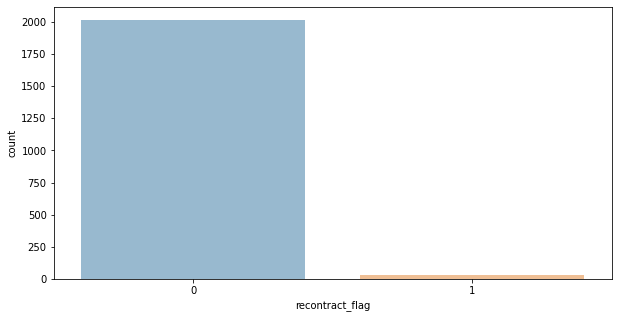

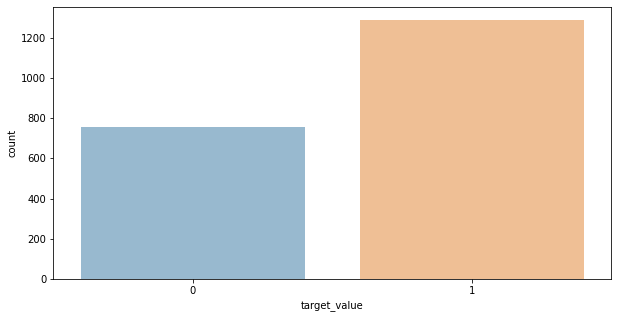

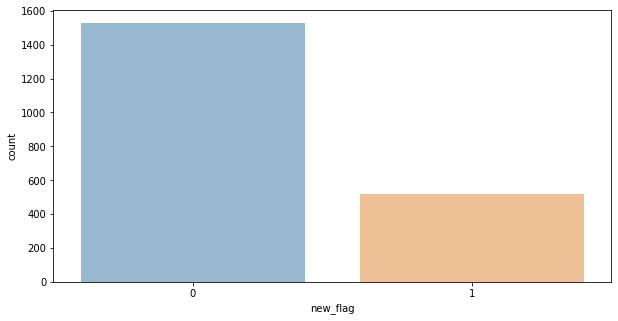

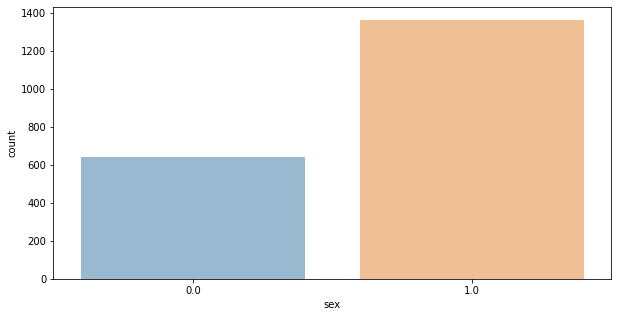

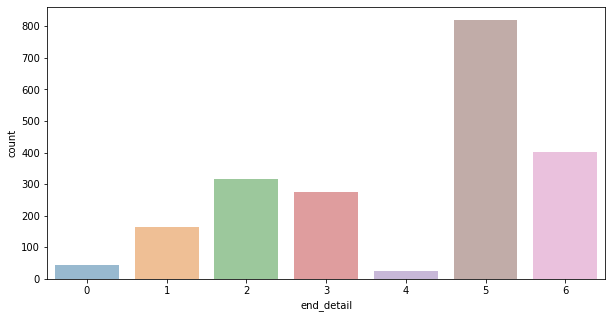

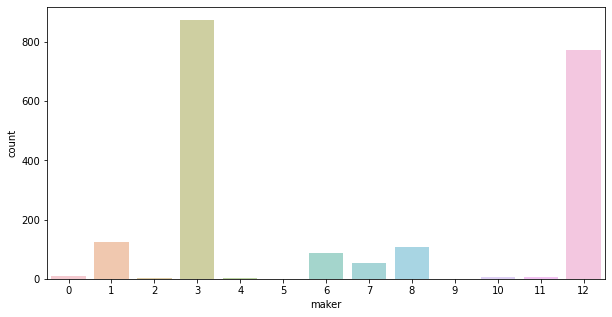

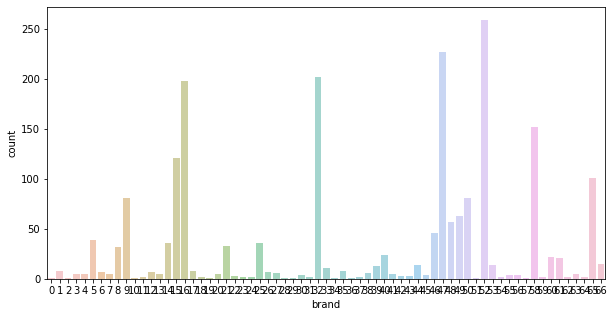

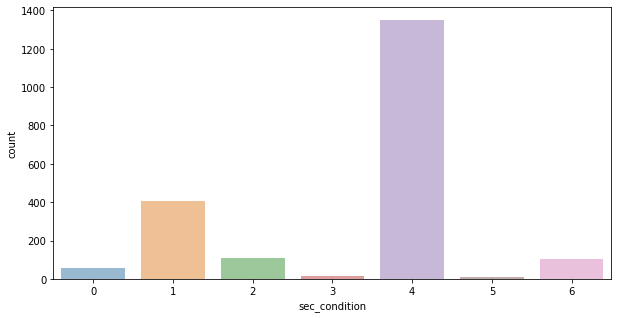

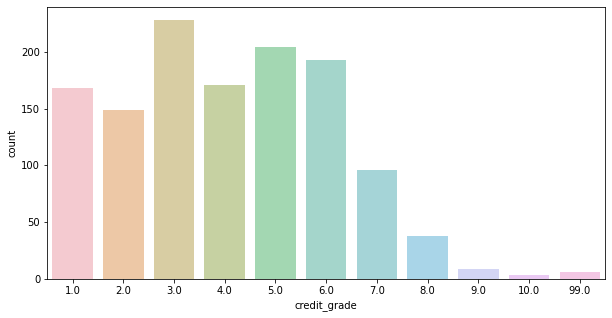

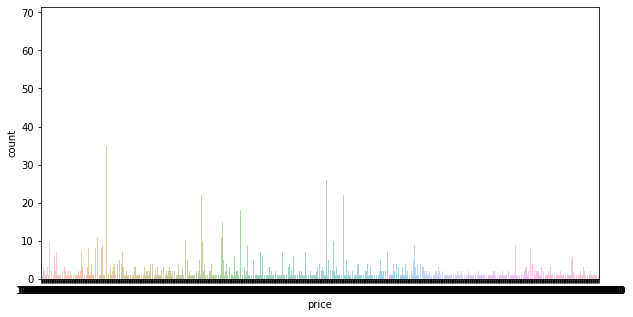

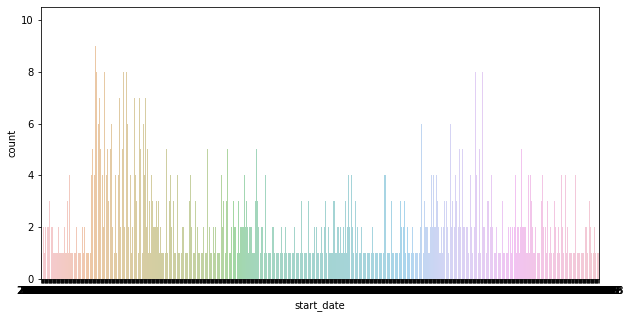

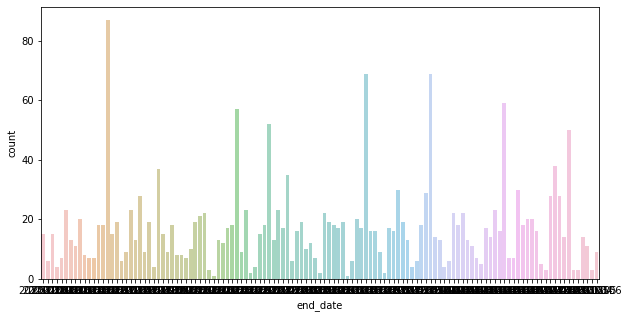

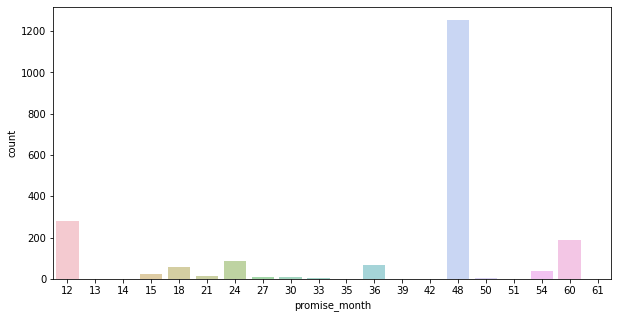

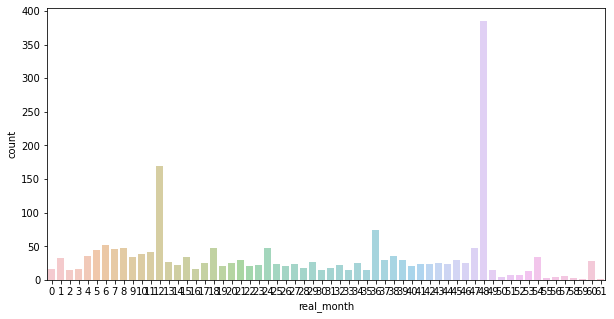

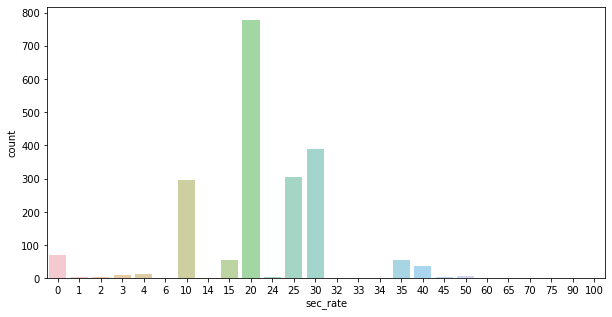

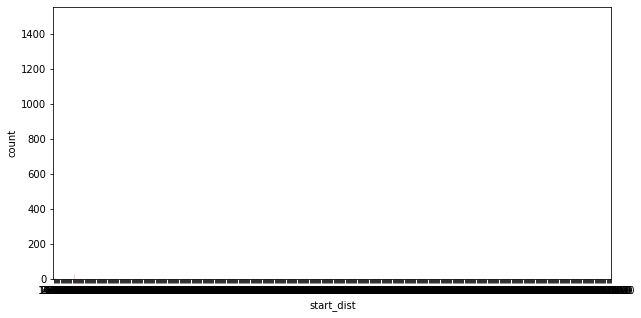

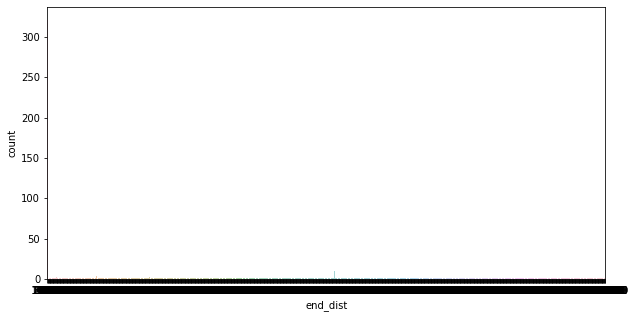

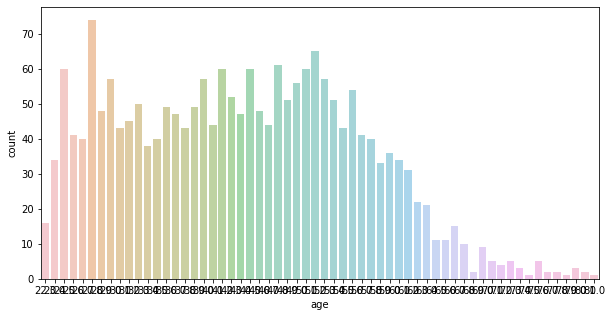

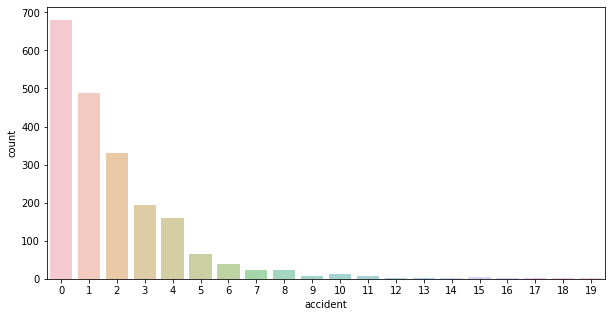

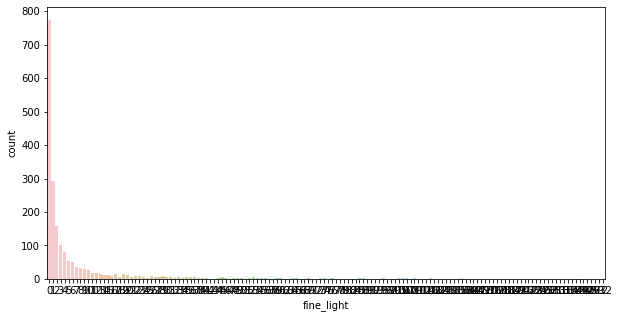

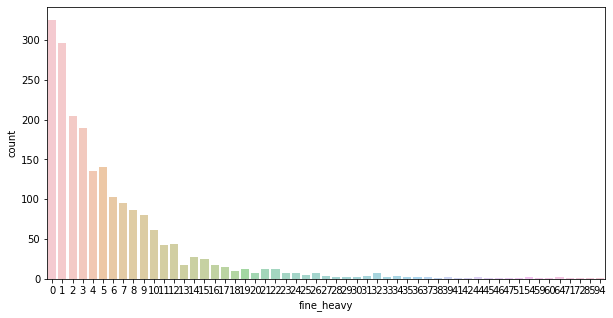

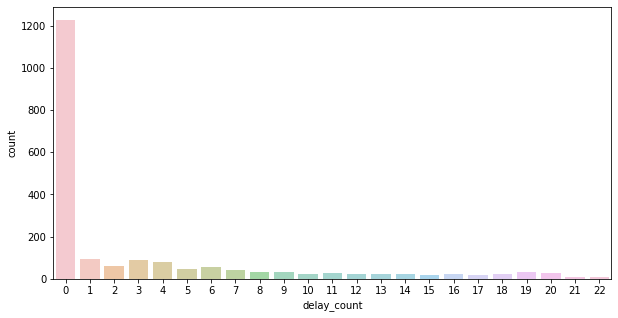

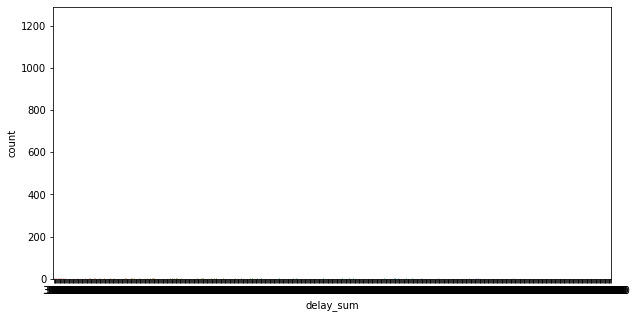

In [ ]:
# 히스토그램 그래프 시각화를 위한 함수
def bar_plot(col, data, hue=None) :
  f, ax = plt.subplots(figsize=(10, 5))
  sns.countplot(x=col, hue=hue, data=data, alpha=0.5)
  plt.show()

for col in binary + category + integer :
  bar_plot(col, dataset)

In [ ]:
# Describe the all statistical properties of the training dataset
dataset[dataset.columns[3073:]].describe()

,MolWt,clogp,sa_score,qed,label
count,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000
mean,443.248753,3.794829,3.187613,0.559151,0.544017
std,88.876374,1.379045,0.727768,0.185664,0.498089
min,94.117000,-4.048930,1.282432,0.024365,0.000000
25%,383.879000,2.874500,2.663425,0.425440,0.000000
50%,441.522000,3.735100,3.093155,0.556410,1.000000
75%,495.639000,4.652500,3.593547,0.700506,1.000000
max,1242.488000,9.429480,7.309297,0.947494,1.000000


In [ ]:
# **** This give you the calulation of the target lebels. Which category of the target lebel is how many percentage.
total_len = len(dataset['label'])
percentage_labels = (dataset['label'].value_counts()/total_len)*100
percentage_labels

1    54.401725
0    45.598275
Name: label, dtype: float64

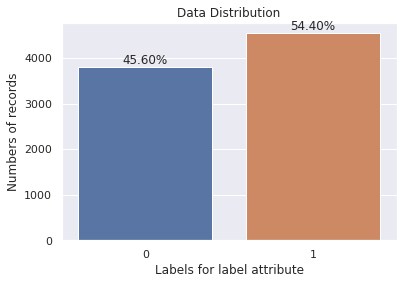

In [ ]:
# Graphical representation of the target label percentage.
sns.set()
sns.countplot(dataset.label).set_title('Data Distribution')
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            '{:.2f}%'.format(100*(height/total_len)),
            fontsize=12, ha='center', va='bottom')
sns.set(font_scale=1.5)
ax.set_xlabel("Labels for label attribute")
ax.set_ylabel("Numbers of records")
plt.show()

In [ ]:
# You will get to know which column has missing value and it's give the count that how many records are missing 
dataset.isnull().sum()

SMILES      0
ecfp_0      0
ecfp_1      0
ecfp_2      0
ecfp_3      0
           ..
MolWt       0
clogp       0
sa_score    0
qed         0
label       0
Length: 3078, dtype: int64

In [ ]:
# graphical missing value 
x = dataset.columns
y = dataset.isnull().sum()
sns.set()
sns.barplot(x,y)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            int(height),
            fontsize=14, ha='center', va='bottom')
sns.set(font_scale=1.5)
ax.set_xlabel("Data Attributes")
ax.set_ylabel("count of missing records for each attribute")
plt.xticks(rotation=90)
plt.show()

In [ ]:
training_data[training_data.columns[1:3077]].corr()

In [ ]:
sns.set()
sns.set(font_scale=1.25)
sns.heatmap(training_data[training_data.columns[1:3077]].corr(),annot=True,fmt=".1f")
plt.show()

### Feature Importance

In [ ]:
#from sklearn.ensemble import RandomForestClassifier

In [ ]:
# 예측변수와 target label 설정
X = dataset.drop(['SMILES','label'], axis=1)

In [ ]:
X_ecfp = X[X.columns[:1024]]

In [ ]:
X_mo = X[X.columns[-4:]]

In [ ]:
X_ecfp_mo = X.drop(X.columns[1024:3072], axis=1)

In [ ]:
X_fcfp = X[X.columns[1024:2048]]

In [ ]:
X_ptfp = X[X.columns[2048:3072]]

In [ ]:
# 분자 특성값을 scaling
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

X_ecfp_mo[['MolWt','clogp','sa_score','qed']] = min_max_scaler.fit_transform(X_ecfp_mo[['MolWt','clogp','sa_score','qed']])

In [ ]:
# target class 정의
y = dataset.label

In [ ]:
print(X_ecfp_mo)

In [ ]:
X = X_ecfp
#X = X_mo
#X = X_ecfp_mo
#X = X_fcfp
#X = X_ptfp

In [ ]:
# Feature 추가 
X['bin_sum'] = X[X.columns[:1024]].sum(axis=1)

In [ ]:
# 예측변수와 target label 설정
X = X.drop(['fcfp_sum','ptfp_sum'], axis=1)

In [ ]:
X = X.drop(['ecfp_sum'], axis=1)

In [ ]:
X

In [ ]:
features_label = X.columns[:]

In [ ]:
# 상관 관계
X_mo.corr()

,MolWt,clogp,sa_score,qed,label
MolWt,1.000000,0.341964,0.405791,-0.747186,-0.005710
clogp,0.341964,1.000000,-0.147969,-0.442464,-0.273023
sa_score,0.405791,-0.147969,1.000000,-0.161738,0.077903
qed,-0.747186,-0.442464,-0.161738,1.000000,0.083707
label,-0.005710,-0.273023,0.077903,0.083707,1.000000


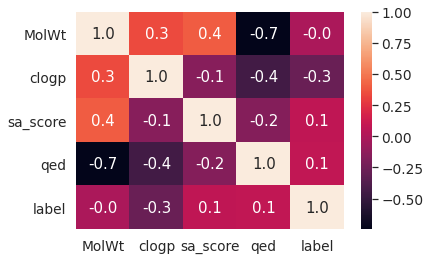

In [ ]:
sns.set()
sns.set(font_scale=1.25)
sns.heatmap(X_mo.corr(),annot=True,fmt=".1f")
plt.show()

In [ ]:
# 변수 중요도 계산
forest = RandomForestClassifier (n_estimators = 10000, random_state=0, n_jobs = -1)
forest.fit(X, y)
importances = forest.feature_importances_
indices = np. argsort(importances)[::-1]
for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label[i],importances[indices[i]]))

 1) ecfp_0                         0.286977
 2) ecfp_1                         0.250486
 3) ecfp_2                         0.231584
 4) ecfp_3                         0.230952


In [ ]:
# Feature 중요순으로 그래프 그리기
plt.title('Feature Importances')
plt.bar(range(X.shape[1]),importances[indices], color="green", align="center")
plt.xticks(range(X.shape[1]),features_label, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

###Train and build baseline model

####데이터 분할

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
print(X);print(y)

In [ ]:
# X, y 훈련, 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [ ]:
print(X_train); print(X_test); print(y_train); print(y_test);

####KNN

In [ ]:
# 모델 정의
#knMod = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2,
#                             metric='minkowski', metric_params=None)
knMod = KNeighborsClassifier()
# 모델 피팅
knMod.fit(X_train, y_train)
# 모델 예측
kn_pred_labels = knMod.predict(X_test.values)

####Logistic Regression

In [ ]:
# 모델 정의
#glmMod = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
#                            intercept_scaling=1, class_weight=None, 
#                            random_state=None, solver='liblinear', max_iter=100,
#                            multi_class='ovr', verbose=2)
glmMod = LogisticRegression()
# 모델 피팅
glmMod.fit(X_train, y_train)
# 모델 예측
glm_pred_labels = glmMod.predict(X_test.values)

####Random Forest

In [ ]:
# 모델 정의
#rfMod = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
#                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
#                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, 
#                               random_state=None, verbose=0)
rfMod = RandomForestClassifier()
# 모델 피팅
rfMod.fit(X_train, y_train)
# 모델 예측
rf_pred_labels = rfMod.predict(X_test.values)

In [ ]:
print("------ RF ------")
print(classification_report(y_test, rf_pred_labels, digits=4))

------ RF ------
              precision    recall  f1-score   support

           0     0.7725    0.7828    0.7776       373
           1     0.8228    0.8139    0.8183       462

    accuracy                         0.8000       835
   macro avg     0.7976    0.7983    0.7980       835
weighted avg     0.8003    0.8000    0.8001       835



####Ada Boost

In [ ]:
# 모델 정의
#adaMod = AdaBoostClassifier(base_estimator=None, n_estimators=200, learning_rate=1.0)
adaMod = AdaBoostClassifier()
# 모델 피팅
adaMod.fit(X_train, y_train)
# 모델 예측
ada_pred_labels = adaMod.predict(X_test.values)

####Gradient Boosting

In [ ]:
# 모델 정의
#gbMod = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
#                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#                                   max_depth=3,
#                                   init=None, random_state=None, max_features=None, verbose=0)
gbMod = GradientBoostingClassifier()
# 모델 피팅
gbMod.fit(X_train, y_train)
# 모델 예측
gb_pred_labels = gbMod.predict(X_test.values)

####XGBoost

In [ ]:
import xgboost as xgb
from xgboost import plot_importance

In [ ]:
print(xgb.__version__)

0.90


In [ ]:
xgMod = xgb.XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=4)

xgMod.fit(X_train, y_train)
xg_pred_labels = xgMod.predict(X_test)

In [ ]:
print("------ XGB ------")
print(classification_report(y_test, xg_pred_labels, digits=4))

------ XGB ------
              precision    recall  f1-score   support

           0     0.7804    0.7909    0.7856       373
           1     0.8293    0.8203    0.8248       462

    accuracy                         0.8072       835
   macro avg     0.8049    0.8056    0.8052       835
weighted avg     0.8075    0.8072    0.8073       835



In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgbmMod, ax=ax)

####LightGBM

In [ ]:
from lightgbm import LGBMClassifier, plot_importance

In [ ]:
import lightgbm
print(lightgbm.__version__)

2.2.3


In [ ]:
lgbmMod = LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=4)
#lgbmMod = LGBMClassifier()
lgbmMod.fit(X_train, y_train)
lgbm_pred_labels = lgbmMod.predict(X_test)

In [ ]:
print("------ LGBM ------")
print(classification_report(y_test, lgbm_pred_labels, digits=4))

------ LGBM ------
              precision    recall  f1-score   support

           0     0.7844    0.8097    0.7968       373
           1     0.8422    0.8203    0.8311       462

    accuracy                         0.8156       835
   macro avg     0.8133    0.8150    0.8140       835
weighted avg     0.8164    0.8156    0.8158       835



In [ ]:
fig, ax = plt.subplots(figsize=(10, 240))
plot_importance(lgbmMod, ax=ax)

#### Model Evaluation

In [ ]:
# 성능 평가
print("------ KNN ------")
print(classification_report(y_test, kn_pred_labels, digits=4))
print("------ GLM ------")
print(classification_report(y_test, glm_pred_labels, digits=4))
print("------ ADA ------")
print(classification_report(y_test, ada_pred_labels, digits=4))
print("------ GB ------")
print(classification_report(y_test, gb_pred_labels, digits=4))
print("------ RF ------")
print(classification_report(y_test, rf_pred_labels, digits=4))
print("------ XGB ------")
print(classification_report(y_test, xg_pred_labels, digits=4))
print("------ LGBM ------")
print(classification_report(y_test, lgbm_pred_labels, digits=4))
## 결과 
# KNN : F1-0.7801, ACC-0.7667
#  RF : F1-0.7652, ACC-0.7519

###Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
# LightGBM 교차 검증
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(lgbmMod, X, y, cv=kfold, verbose=1, n_jobs=-1, scoring='f1')
print("LightGBM 교차 검증 평균 점수 :  {:.4f}".format(scores.mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LightGBM 교차 검증 평균 점수 :  0.8107


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished


In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(rfMod, X, y, cv=kfold, verbose=1, n_jobs=-1, scoring='f1')
print("RandomForest 교차 검증 평균 점수 :  {:.4f}".format(scores.mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RandomForest 교차 검증 평균 점수 :  0.8200


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   49.9s finished


In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(xgMod, X, y, cv=kfold, verbose=1, n_jobs=-1, scoring='f1')
print("XGB 교차 검증 평균 점수 :  {:.4f}".format(scores.mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


XGB 교차 검증 평균 점수 :  0.8149


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 39.7min finished


###Hyper parameter optimization using Randomized search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint

####light GBM Param Tuning

In [ ]:
# 하이퍼 파라미터 후보값 셋팅
lgbmHyperParams = {
    'n_estimators': randint(100, 1000), # randint(100, 1000) > 847
    'learning_rate': [0.01, 0.1, 0.3], # [0.01, 0.1, 0.3] > 0.1
    'num_leaves': randint(16, 108), # randint(16, 108) > 105
    'max_depth':  randint(-1, 100), # randint(-1, 100) > 24
    'min_child_samples': randint(20, 120) # randint(20, 120) > 81
    # best_score=0.8173
}

In [ ]:
# 하이퍼 파라미터 튜닝
gridSearchLgbm = RandomizedSearchCV(estimator=lgbmMod, param_distributions=lgbmHyperParams, n_iter=10,
                                    scoring='f1', cv=None, verbose=2, n_jobs=-1, random_state=234).fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 26.2min finished


In [ ]:
# 하이퍼 파라미터 후보값 중 최적값 확인
gridSearchLgbm.best_params_, gridSearchLgbm.best_score_

({'learning_rate': 0.01,
  'max_depth': 36,
  'min_child_samples': 27,
  'n_estimators': 870,
  'num_leaves': 97},
 0.8186260959307716)

In [ ]:
# 하이퍼 파라미터 후보값 셋팅
lgbmHyperParams = {
    'n_estimators': [100, 400, 800],
    'learning_rate': [0.01, 0.1, 0.3],
    'num_leaves': [15, 31, 63, 127],
    'max_depth':  [4, 8, 16, -1],
    'min_child_samples': [20, 40, 80, 120],
    'subsample': [0.6, 0.7, 0.8, 1.0]
}

In [ ]:
# 하이퍼 파라미터 튜닝
gridSearchLgbm = GridSearchCV(estimator=lgbmMod, param_grid=lgbmHyperParams,
                                    scoring='f1', cv=5, verbose=2, n_jobs=-1).fit(X_train, y_train)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 55.4min


####xg Boost Param Tuning

In [ ]:
# 하이퍼 파라미터 후보값 셋팅
xgHyperParams = {
    'n_estimators': randint(100, 600),
    'max_depth': randint(1,10)
    }

In [ ]:
# 하이퍼 파라미터 튜닝

gridSearchXg = RandomizedSearchCV(estimator=xgMod, param_distributions=xgHyperParams, n_iter=10,
                                   scoring='f1', cv=None, verbose=2).fit(X_train, y_train)

In [ ]:
# 하이퍼 파라미터 후보값 중 최적값 확인
gridSearchXg.best_params_, gridSearchXg.best_score_

({'max_depth': 8, 'n_estimators': 324}, 0.8174254246893543)

In [ ]:
# Best XGBoost Param 으로 다시 훈련
bestXgbModFitted = gridSearchXg.best_estimator_.fit(X_train, y_train)

In [ ]:
best_xgb_pred_labels = bestXgbModFitted.predict(X_test)

####Train models with help of new hyper parameter

In [ ]:
# Best LightGBM Param 으로 다시 훈련
bestLgbmModFitted = gridSearchLgbm.best_estimator_.fit(X_train, y_train)

In [ ]:
# Best LightGBM Param CV, 모델 검증 
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(bestLgbmModFitted, X, y, cv=kfold, verbose=1, n_jobs=-1, scoring='f1')
print("LightGBM 교차 검증 평균 점수 :  {:.4f}".format(scores.mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LightGBM 교차 검증 평균 점수 :  0.8284


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 12.7min finished


In [ ]:
best_lgbm_pred_labels = bestLgbmModFitted.predict(X_test.values)

In [ ]:
print("------ Best LGBM Param Predict ------")
print(classification_report(y_test, best_lgbm_pred_labels, digits=4))

------ Best LGBM Param Predict ------
              precision    recall  f1-score   support

           0     0.7963    0.8070    0.8016       373
           1     0.8425    0.8333    0.8379       462

    accuracy                         0.8216       835
   macro avg     0.8194    0.8202    0.8197       835
weighted avg     0.8218    0.8216    0.8217       835



In [ ]:
# Feature 추가
X['ecfp_sum'] = X[X.columns[:1024]].sum(axis=1)
X['fcfp_sum'] = X[X.columns[1024:2048]].sum(axis=1)
X['ptfp_sum'] = X[X.columns[2048:3072]].sum(axis=1)

In [ ]:
# 추가된 Feature에서 Best LightGBM Param 으로 다시 훈련
bestLgbmModFitted_added = gridSearchLgbm.best_estimator_.fit(X_train, y_train)

In [ ]:
# 10 Fold CV로 검증
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(bestLgbmModFitted_added, X, y, cv=kfold, verbose=1, n_jobs=-1, scoring='f1')
print("LightGBM 교차 검증 평균 점수 :  {:.4f}".format(scores.mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LightGBM 교차 검증 평균 점수 :  0.8280


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 13.2min finished


In [ ]:
# 변수 중요도 확인
fig, ax = plt.subplots(figsize=(10, 240))
plot_importance(bestLgbmModFitted_added, ax=ax)

In [ ]:
# Best GB Param
bestGbModFitted = gridSearchGB.best_estimator_.fit(X_train, y_train)

In [ ]:
# Best GB, KNN CV
cvDictbestpara = cvDictGen(functions=[bestGbModFitted, bestKnModFitted], scr='f1')
cvDictbestpara

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 19.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.6min finished


{'GradientBoostingClassifier': [0.7281134192267799, 0.041367661735124385],
 'KNeighborsClassifier': [0.7080833067379293, 0.04502954489265975]}

In [ ]:
# Best GB Pred
best_gb_pred_labels=bestGbModFitted.predict(X_test.values)

In [ ]:
# Best GB 성능 평가
print("------ RF ------")
print(classification_report(y_test, best_gb_pred_labels, digits=4))

------ RF ------
              precision    recall  f1-score   support

           0     0.7580    0.7641    0.7610       373
           1     0.8083    0.8030    0.8056       462

    accuracy                         0.7856       835
   macro avg     0.7831    0.7836    0.7833       835
weighted avg     0.7858    0.7856    0.7857       835



###Feature Transformation

####Log Transform

In [ ]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)
X_train_1 = np.array(X_train)
X_train_transform = transformer.transform(X_train_1)

In [ ]:
bestGbModFitted_transformed = gridSearchGB.best_estimator_.fit(X_train_transform, y_train)

In [ ]:
bestAdaModFitted_transformed = gridSearchAda.best_estimator_.fit(X_train_transform, y_train)

In [ ]:
cvDictbestpara_transform = cvDictGen(functions=[bestGbModFitted_transformed, bestAdaModFitted_transformed], scr='roc_auc')

In [ ]:
cvDictbestpara_transform

In [ ]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

In [ ]:
transformer = FunctionTransformer(np.log1p)
X_test_1 = np.array(X_test)
X_test_transform = transformer.transform(X_test_1)

In [ ]:
X_test_transform

In [ ]:
test_labels=bestGbModFitted_transformed.predict_proba(np.array(X_test_transform))[:,1]

In [ ]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

In [ ]:
test_labels=bestAdaModFitted_transformed.predict_proba(np.array(X_test_transform))[:,1]

In [ ]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

####Voting based ensemble model

In [ ]:
bestGbModFitted_transformed = bestGbModFitted
bestKnModFitted_transformed = bestKnModFitted
X_train_transform = X_train
X_test_transform = X_test

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
votingMod = VotingClassifier(estimators=[('lgbm', bestLgbmModFitted), 
                                         ('xgb', bestXgbModFitted)], voting='soft')#,weights=[2,1])
votingMod = votingMod.fit(X_train, y_train)

In [ ]:
ens_pred_labels = votingMod.predict(X_test)

In [ ]:
# Ensembled GB, KNN 성능 평가
print("------ RF ------")
print(classification_report(y_test, ens_pred_labels, digits=4))

------ RF ------
              precision    recall  f1-score   support

           0     0.7963    0.8177    0.8069       373
           1     0.8496    0.8312    0.8403       462

    accuracy                         0.8251       835
   macro avg     0.8230    0.8244    0.8236       835
weighted avg     0.8258    0.8251    0.8253       835



In [ ]:
# Stacking Ensemble
pred = np.array([best_lgbm_pred_labels, best_xgb_pred_labels])

In [ ]:
pred = np.transpose(pred)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
lr_final = LogisticRegression(C=10)

In [ ]:
lr_final.fit(pred, y_test)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
final = lr_final.predict(pred)

In [ ]:
print('최종 메타 모델 예측 정확도:{0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델 예측 정확도:0.8180


In [ ]:
roc_auc_score(y_test, pred_labels , average='macro', sample_weight=None)

In [ ]:
from sklearn.ensemble import VotingClassifier
votingMod_old = VotingClassifier(estimators=[('gb', bestGbModFitted), ('ada', bestAdaModFitted)], 
                                 voting='soft',weights=[2,1])
votingMod_old = votingMod.fit(X_train, y_train)

In [ ]:
test_labels = votingMod_old.predict_proba(np.array(X_test.values))[:,1]

In [ ]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

###Testing on Real Test Dataset

In [ ]:
# Read Training dataset as well as drop the index column
test_data = pd.read_csv('./data/cs-test.csv').drop('Unnamed: 0', axis = 1)
# For each column heading we replace "-" and convert the heading in lowercase 
cleancolumn = []
for i in range(len(test_data.columns)):
    cleancolumn.append(test_data.columns[i].replace('-', '').lower())
test_data.columns = cleancolumn

In [ ]:
test_data.drop(['seriousdlqin2yrs'], axis=1, inplace=True)
test_data.fillna((training_data.median()), inplace=True)

In [ ]:
test_labels_votingMod_old = votingMod_old.predict_proba(np.array(test_data.values))[:,1]
print (len(test_labels_votingMod_old))

In [ ]:
output = pd.DataFrame({'ID':test_data.index, 'probability':test_labels_votingMod_old})

In [ ]:
output.to_csv("./predictions.csv", index=False)

In [ ]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)
test_data_temp = np.array(test_data)
test_data_transform = transformer.transform(test_data_temp)

In [ ]:
test_labels_votingMod = votingMod.predict_proba(np.array(test_data.values))[:,1]
print (len(test_labels_votingMod_old))

In [ ]:
output = pd.DataFrame({'ID':test_data.index, 'probability':test_labels_votingMod})

In [ ]:
output.to_csv("./predictions_voting_Feature_transformation.csv", index=False)